<a href="https://colab.research.google.com/github/VictorFreir/Twitter-Sentiment-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Hey there!</h1>
<h3>Seja muito bem vindo e sinta-se no seu próprio repositório.</h3>
<p>Dev, se acomode, sirva seu café, pois nós hoje vamos tentar prever se um tumor é maligno ou benigno baseado em suas características.
</p>



# Introdução

<p>Antes de começarmos a codar a todo vapor, vamos entender o problema que queremos solucionar. Nós queremos prever se um tweet tem sentimento positivo, negativo ou neutro. Para isso, nós utilizaremos o algoritmo de Naive Bayes. Além disso, utilizaremos a base de dados <a href="https://www.kaggle.com/saurabhshahane/twitter-sentiment-dataset">Twitter Sentiment Dataset</a>, que pode ser encontrada no <a href="https://www.kaggle.com/">Kaggle</a>. Bem, tendo identificado o problema, nós podemos ir para a parte divertida, o código!

<p>Começaremos importanto as bibliotecas e base de dados que utilizaremos</p>

In [17]:
!pip install wordcloud -q

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [19]:
df = pd.read_csv('/content/Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


<p>Acima estão as 5 primeiras linhas da nossa base, tendo na primeira coluna o texto do tweet e na segunda temos as categórias, ou seja, o sentimento do tweet, que pode ser:</p>
<p>-1 = negativo</p>
<p>0 = neutro</p>
<p>1 = positivo</p>

# Limpeza dos dados

<p>Antes de seguirmos para a criação do nosso modelo de Machine Learning, nós precisamos realizar a limpeza dos dados e nos certificarmos de estarem prontos para a utilização. Iremos começar identificando se existem dados faltantes:</p>

In [20]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

<p>Tendo visto que existem dados faltantes vamos remover-los do nosso DataFrame:</p>

In [21]:
df = df.dropna()

<p>Bem, aqui nossos dados já estão limpos, nós podemos agora tentar fazer algumas análises com esses dados.</p>

# Análise dos dados

Por os dados serem palavras, não conseguimos utilizar de ferramentas estatística descritiva convencionais nas análises de dados, como média, desvio padrão, mediana entre outras. Então, começaremos vendo a proporção de tweets em cada sentimento:

Text(0.5, 0, 'Sentimento')

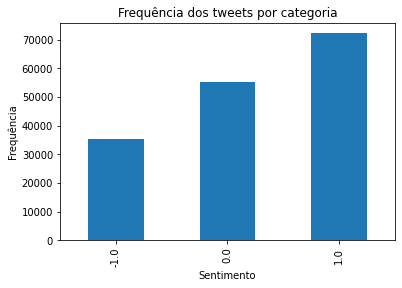

In [22]:
df.groupby('category').category.count().plot(kind='bar')
plt.title('Frequência dos tweets por categoria')
plt.ylabel('Frequência')
plt.xlabel('Sentimento')

<p>Vemos que temos bem mais tweets positivos do que negativos.</p>
<p>"Victor, essa vai ser a única análise que a gente vai conseguir fazer?" Longe disso, meu jovem gafanhoto, nós podemos ver o seguinte:</p>

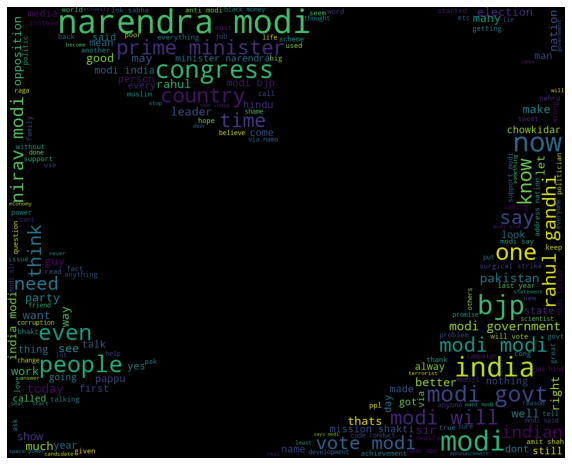

In [23]:
mask = np.array(Image.open('/content/twitter_logo.png'))
text = df.clean_text.tolist()
text = ' '.join(text).lower()
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="black",
                      width=1000, height=2000, max_words=200,
                      mask=mask, max_font_size=200,
                      min_font_size=1).generate(text)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud)

<p>Vemos que existem muitas palavras que se repetem muito nos tweets, como even, today, good, know, dentre outras. </p>

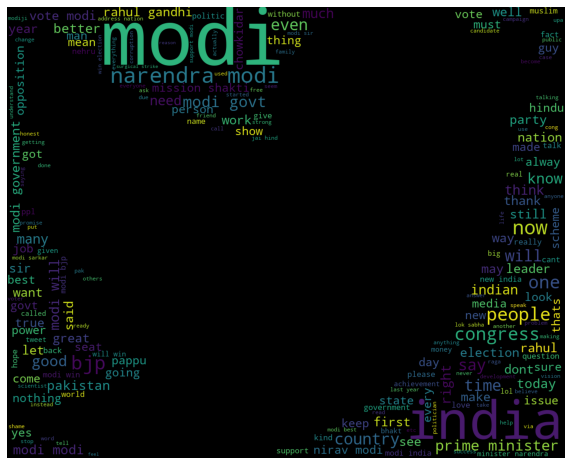

In [24]:
mask = np.array(Image.open('/content/twitter_logo.png'))
text = df[df.category == 1].clean_text.tolist()
text = ' '.join(text).lower()
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="black",
                      width=1000, height=2000, max_words=200,
                      mask=mask, max_font_size=200,
                      min_font_size=1).generate(text)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud)

<p>Aparantemente, Narendra Modi, primeiro ministro da India está sendo fortemente relacionado de forma positivas nos tweets. Se você não entendeu a nuvem de palavras acima, ela mostra as palavras de maiores frequências apenas nos tweets de sentimentos positivos. Vejamos agora nos negativos:</p>

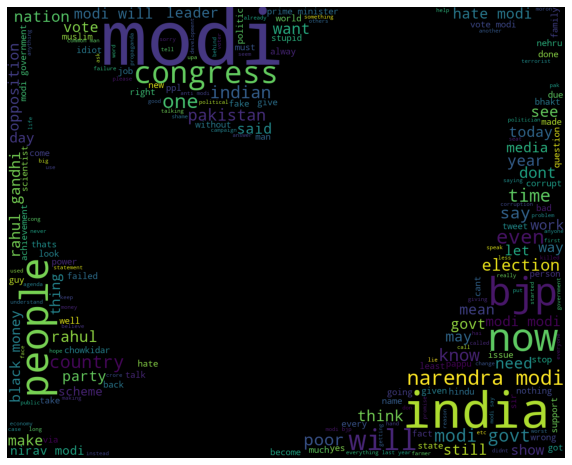

In [25]:
mask = np.array(Image.open('/content/twitter_logo.png'))
text = df[df.category == -1].clean_text.tolist()
text = ' '.join(text).lower()
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="black",
                      width=1000, height=2000, max_words=200,
                      mask=mask, max_font_size=200,
                      min_font_size=1).generate(text)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wordcloud)

<p>Ora ora, então, parece que o primeiro ministro não está sendo apenas sendo citado de forma positiva, mas de forma negativa também. Concluímos então que ele é um valor em evidência, mas sozinho não é muito descriminatório. No entanto, vemos que a junção da palavra "hate" com "modi"("hate modi"), está em maior evidência nos tweets negativos. 
</p>
<p>Nosso modelo fará, de forma mais acertiva, um trabalho similar a esse, identificando padrões similares e prevendo com base nas probabilidades anteriores de cada palavra ser de uma certa categporia de sentimento.</p>

# Pré-processamento dos dados

<p>Calma! Já vamos chegar no modelo de Machine Learning, mas antes nós precisamos fazer algumas alterações no nosso dataset. Vamos começar mudando a coluna category, por questões matemáticas, da seguinte forma:</p>
<ul>
<li>Os valores de sentimentos negativos (-1) serão substituídos por 0.
</li>
<li>Os valores de sentimentos neutros (0) serão substituídos por 1.
</li>
<li>Os valores de sentimentos positivos (1) serão substituídos por 2.
</li>

In [26]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

<p>Agora, nós iremos dividir o nosso conjunto de dados em dados de treinamento e dados de testes para que possamos quantificar o rendimento do nosso modelo no final do projeto:</p>

In [27]:
x_train,x_test,y_train,y_test = train_test_split(df['clean_text'],df['category'],random_state=1,test_size=0.05)

<p>"Victor, muito massa tudo isso, mas tu tá esquecendo de uma coisa, se o modelo é matemático como ele vai interpretar as palavras?" SHOW de pergunta! E esse é o próximo passo, nós iremos criar uma tabela de frequência das palavras sendo suas linhas os tweets:</p>

In [28]:
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(x_train)
X_test_cv = cv.transform(x_test)

<p>Tendo feito essa importantissíma etapa do processo, podemos partir para a mais empolgante, o modelo de Machine Learning!</p>

# Machine Learning

<p>Nós utilizaremos o algoritmo de Naive Bayes, que servirá classificando os sentimentos dos tweets com base nas frequências de palavras passadas. Começaremos criando e treinando nosso modelo:</p>

In [29]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

<p>Bem, agora nós podemos prever os valores:</p>

In [30]:
predictions = naive_bayes.predict(X_test_cv)

Podemos agora verificar a acurácia que nosso modelo teve:

In [31]:
print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.7159160633206528


<p>Nosso modelo obteve cerca de 71.5% de acurácia, uma acertividade bem relevante e, por curiosidade, peguei um tweet, no qual a pessoa claramente demonstra felicidade, e colocamos para a IA prever: </p>

In [32]:
text = np.array(['Luke got some feeding too but Earth knew what trick to pull. KHAO IM REALLY SORRY YOU ARE IN THIS AGAIN LOL. And then they leftP.S. THE WHOLE LUKEMIX EARTHKHAO EXCHANGE MADE ME FEEL THINGS'])
u = cv.transform(text)
naive_bayes.predict(u)

array([2])

<p>E ela acertou! É normal que nosso modelo não acerte 90%, por exemplo, pois nas redes sociais - como o Twitter - há diversos empecilhos que precisariamos resolver, como exemplo poderíamos citar a ironia, a qual nosso modelo provavelmente teria dificuldade em classificar. </p>

# Conclusão

<p><p>Chegando, infelizmente, no fim do nosso projeto, nós vamos dar uma breve recapitulada no que fizemos - que não foi pouco viu.</p>
<p>Ao decorrer desse notebook, nós entendemos o problema, fizemos a limpeza e tratamento dos dados, realizamos análise dos dados, criamos, treinamos e aplicamos um modelo de Machine Learning e quantificamos os seus resultados.</p>
<p>Portanto, eu espero que você tenha queimado uns fosfatos e secando sua caneca aqui comigo. Agradeço, imensamente, por ter chegado até o final. Se gostou do meu trabalho, convido-o a acompanhar mais de perto a minha jornada pelo <a href="https://www.linkedin.com/in/victor-vin%C3%ADcius-freire-de-ara%C3%BAjo-bb3782207/">LinkedIn</a> ou <a hef="https://github.com/VictorFreir">GitHub</a>.